# Task1   Data Acquisition

In [588]:
import os
import csv
import urllib
import json
import math

import pandas as pd
import numpy as np
import datetime
from alpha_vantage.timeseries import TimeSeries
from covid19dh import covid19
import requests
import matplotlib.pyplot as plt
import dataframe_image as dfi
import pickle
import seaborn as sn
from scipy import stats
from matplotlib.ticker import MultipleLocator

import time
from meteostat import Point
from meteostat import Daily

In [567]:
def save_plot(name, plot):
    """
    Function which saves a given image to the corresponding folder.
    """
    plt.tight_layout()# Display appropiately.
    file = os.path.join("./Saved Figures", (str(name) + str(plot) + ".png"))
    plt.savefig(file, bbox_inches = "tight", dpi = 200, pad_inches = 0.2, edgecolor = "white", facecolor = "white")
    plt.close()
    
    return

In [ ]:
start_date = datetime.datetime(2017, 4, 1)
end_date = datetime.datetime(2022, 5, 31)

In [ ]:
def download_save_csv(url,filename):
    """ To download and save .csv file according to url and save path"""
    data_dir='./Dataset'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)    
    file_path=data_dir+'/'+filename+'.csv'
    if not os.path.exists(file_path):
        file_path, headers = urllib.request.urlretrieve(url,file_path)   
    return file_path


In [568]:
def save_file(dir,df,filename):
    df.to_pickle(os.path.join(dir, f'{filename}.pkl'))
    df.to_csv(os.path.join(dir, f'{filename}.csv'))
    

In [569]:
api_key='B1Q551T88OEDZJ52'

In [572]:
datasets_dir='./Datasets'

In [590]:
preprocessed_path='./Preprocessed'

# stock data for APPLE

In [577]:
def acquire_AAPL_data():
    ts = TimeSeries (key=api_key, output_format = "pandas")
    data_daily, meta_data = ts.get_daily_adjusted(symbol='AAPL', outputsize ='full')

    # start_date = datetime.datetime(2017, 4, 1)
    # end_date = datetime.datetime(2022, 5, 31)

    # Create a filtered dataframe, and change the order it is displayed. 
    stock_data = data_daily[(data_daily.index > start_date) & (data_daily.index <= end_date)]
    stock_data = stock_data.sort_index(ascending=True)
    #date_filter
    stock_data = stock_data.rename(columns={'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Original Close',
                                    '5. adjusted close': 'Close', '6. volume': 'Volume', '7. dividend amount': 'Dividend',
                                    '8. split coefficient': 'Split'})
    return stock_data


# Stock data for GOOGLE(GOOG)

In [578]:
def acquire_GOOG_data():
    ts = TimeSeries (key=api_key, output_format = "pandas")
    data_daily, meta_data = ts.get_daily_adjusted(symbol='GOOG', outputsize ='full')

    # start_date = datetime.datetime(2017, 4, 1)
    # end_date = datetime.datetime(2022, 5, 31)

    # Create a filtered dataframe, and change the order it is displayed. 
    stock_data_GOOG = data_daily[(data_daily.index > start_date) & (data_daily.index <= end_date)]
    stock_data_GOOG = stock_data_GOOG.sort_index(ascending=True)
    #date_filter
    stock_data_GOOG = stock_data_GOOG.rename(columns={'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Original Close',
                                    '5. adjusted close': 'Close', '6. volume': 'Volume', '7. dividend amount': 'Dividend',
                                    '8. split coefficient': 'Split'})
    return stock_data_GOOG

In [579]:
stock_AAPL=acquire_AAPL_data()
save_file(datasets_dir,stock_AAPL,'stock_AAPL')

In [360]:
datasets_dir='./Datasets'
stock_filename='AAPL_stock_data'
def store_data_csv():
    
stock_data.to_pickle(os.path.join(datasets_dir, f'{stock_filename}.pkl'))
stock_data.to_csv(os.path.join(datasets_dir, f'{stock_filename}.csv'))

In [576]:
stock_GOOG=acquire_GOOG_data()
save_file(datasets_dir,stock_GOOG,'stock_GOOG')

In [361]:
stock_filename_GOOG='GOOG_stock_data'
stock_data_GOOG.to_pickle(os.path.join(datasets_dir, f'{stock_filename_GOOG}.pkl'))
stock_data_GOOG.to_csv(os.path.join(datasets_dir, f'{stock_filename_GOOG}.csv'))

# Covid Data

In [580]:
def acquire_covid_data():
    df_covid,src=covid19('USA',start=start_date,end=end_date,verbose = False)
    # covid_filename='Covid'
    # df_covid.to_pickle(os.path.join(datasets_dir, f'{covid_filename}.pkl'))
    # df_covid.to_csv(os.path.join(datasets_dir, f'{covid_filename}.csv'))
    return df_covid

In [587]:
covid_data=acquire_covid_data()
save_file(datasets_dir,covid_data,'Covid')

# Weather Data

In [589]:
from meteostat import Point
from meteostat import Daily
def acquire_Cupertino_weather():
    location=Point(37.323,-122.032,70)
    data=Daily(location, start_date, end_date)
    cupertino_weather=data.fetch()
    return cupertino_weather

weather_data=acquire_Cupertino_weather()
save_file(datasets_dir,weather_data,'Weather')
# location = Point(37.323,-122.032,70)
# data = Daily(location, start_date, end_date)
# weather_filename='Cupertino_weather_2017_22'
# cupertino_weather = data.fetch()
# cupertino_weather.to_csv(os.path.join(datasets_dir, f'{weather_filename}.csv'))
# cupertino_weather.to_pickle(os.path.join(datasets_dir, f'{weather_filename}.pkl'))

# Task3 Data Preprocessing

In [ ]:
def preprocessing(pdates,stock_data,):


In [364]:
pdates = pd.date_range(start=start_date, end=end_date)
preprocessed_path='./Preprocessed'

In [365]:
stock_pre_filename='AAPL_stock_data_pre'
#stock_time_series=stock_data['Close']
stock_pre=stock_AAPL.drop(['Open','High','Low','Original Close','Volume','Dividend','Split'],axis=1)
print(stock_pre) #dataframe
stock_pre_nan=stock_pre.reindex(pdates, fill_value=np.nan)
print(stock_pre_nan) #dataframe

                 Close
date                  
2017-04-03   33.718447
2017-04-04   33.969517
2017-04-05   33.793534
2017-04-06   33.709062
2017-04-07   33.633975
...                ...
2022-05-24  139.755770
2022-05-25  139.915081
2022-05-26  143.161047
2022-05-27  148.995821
2022-05-31  148.199264

[1300 rows x 1 columns]
                 Close
2017-04-01         NaN
2017-04-02         NaN
2017-04-03   33.718447
2017-04-04   33.969517
2017-04-05   33.793534
...                ...
2022-05-27  148.995821
2022-05-28         NaN
2022-05-29         NaN
2022-05-30         NaN
2022-05-31  148.199264

[1887 rows x 1 columns]


In [371]:
stock_pre_nan.to_csv(os.path.join(preprocessed_path,f'{stock_pre_filename}.csv'))
stock_pre_nan.to_pickle(os.path.join(preprocessed_path,f'{stock_pre_filename}.pkl'))

In [372]:
#stock_data_GOOG

stock_pre_filename_GOOG='GOOG_stock_data_pre'
#stock_time_series=stock_data['Close']
stock_pre_GOOG=stock_data_GOOG.drop(['Open','High','Low','Original Close','Volume','Dividend','Split'],axis=1)
print(stock_pre_GOOG) #dataframe
stock_pre_nan_GOOG=stock_pre_GOOG.reindex(pdates, fill_value=np.nan)
print(stock_pre_nan_GOOG) #dataframe
stock_pre_nan_GOOG.to_csv(os.path.join(preprocessed_path,f'{stock_pre_filename_GOOG}.csv'))
stock_pre_nan_GOOG.to_pickle(os.path.join(preprocessed_path,f'{stock_pre_filename_GOOG}.pkl'))

               Close
date                
2017-04-03   41.9275
2017-04-04   41.7285
2017-04-05   41.5705
2017-04-06   41.3940
2017-04-07   41.2335
...              ...
2022-05-24  105.9260
2022-05-25  105.8395
2022-05-26  108.2960
2022-05-27  112.7990
2022-05-31  114.0390

[1300 rows x 1 columns]
               Close
2017-04-01       NaN
2017-04-02       NaN
2017-04-03   41.9275
2017-04-04   41.7285
2017-04-05   41.5705
...              ...
2022-05-27  112.7990
2022-05-28       NaN
2022-05-29       NaN
2022-05-30       NaN
2022-05-31  114.0390

[1887 rows x 1 columns]


In [594]:
covid_pre_filename='covid_pre'
#stock_time_series=stock_data['Close']
covid_pre=covid_data[['date', 'confirmed']]
covid_pre.set_index('date',inplace=True)
covid_pre["daily_confirmed"] = np.insert(np.diff(covid_pre.values.flatten()), 0, 0)
#print(covid_pre)
covid_daily_pre=covid_pre[['daily_confirmed']]
print(covid_daily_pre)
covid_pre_nan=covid_pre.reindex(pdates,fill_value=np.nan)
covid_pre_confirmed=covid_pre[['confirmed']]
print(covid_pre_confirmed)

            daily_confirmed
date                       
2020-01-21              0.0
2020-01-22              0.0
2020-01-23              0.0
2020-01-24              1.0
2020-01-25              1.0
...                     ...
2022-05-27         138911.0
2022-05-28          13762.0
2022-05-29           9045.0
2022-05-30          32152.0
2022-05-31         182383.0

[862 rows x 1 columns]
             confirmed
date                  
2020-01-21         1.0
2020-01-22         1.0
2020-01-23         1.0
2020-01-24         2.0
2020-01-25         3.0
...                ...
2022-05-27  83903655.0
2022-05-28  83917417.0
2022-05-29  83926462.0
2022-05-30  83958614.0
2022-05-31  84140997.0

[862 rows x 1 columns]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [388]:
covid_pre_nan_filename='covid_pre_nan'
covid_pre_nan.to_csv(os.path.join(preprocessed_path,f'{covid_pre_nan_filename}.csv'))
covid_pre_nan.to_pickle(os.path.join(preprocessed_path,f'{covid_pre_nan_filename}.pkl'))

In [396]:
covid_daily_pre

,daily_confirmed
date,
2020-01-21,0.0
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,1.0
...,...
2022-05-27,138911.0
2022-05-28,13762.0
2022-05-29,9045.0


In [398]:
covid_daily_pre_0=covid_daily_pre
covid_daily_pre_0

,daily_confirmed
date,
2020-01-21,0.0
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,1.0
...,...
2022-05-27,138911.0
2022-05-28,13762.0
2022-05-29,9045.0


In [ ]:
# covid_pre_0=covid_pre.reindex(pdates,fill_value=0)
# covid_pre_0["daily_confirmed"] = np.insert(np.diff(covid_pre_0.values.flatten()), 0, 0)
# covid_daily_pre_0=covid_pre_0[['daily_confirmed']]
# #type(covid_daily_pre_0)

In [252]:
covid_daily_pre_filename='covid_daily_pre'
covid_daily_pre.to_csv(os.path.join(preprocessed_path,f'{covid_daily_pre_filename}.csv'))
covid_daily_pre.to_pickle(os.path.join(preprocessed_path,f'{covid_daily_pre_filename}.pkl'))

In [399]:
covid_pre_confirmed

,confirmed
date,
2020-01-21,1.0
2020-01-22,1.0
2020-01-23,1.0
2020-01-24,2.0
2020-01-25,3.0
...,...
2022-05-27,83903655.0
2022-05-28,83917417.0
2022-05-29,83926462.0


In [400]:
covid_pre_confirmed.to_csv(os.path.join(preprocessed_path,f'{covid_pre_filename}.csv'))
covid_pre_confirmed.to_pickle(os.path.join(preprocessed_path,f'{covid_pre_filename}.pkl'))

# Weather Data

In [401]:
cupertino_weather

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2017-04-01,17.4,9.7,25.3,0.0,0.0,NaN,7.5,NaN,1015.7,NaN
2017-04-02,16.8,10.3,24.7,0.0,0.0,NaN,10.2,NaN,1015.3,NaN
2017-04-03,15.4,9.7,21.9,0.0,0.0,NaN,11.8,NaN,1014.9,NaN
2017-04-04,15.2,7.5,23.0,0.0,0.0,NaN,8.7,NaN,1016.5,NaN
2017-04-05,17.4,11.9,24.1,0.0,0.0,NaN,8.4,NaN,1016.3,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-05-27,17.0,13.6,21.9,0.0,NaN,338.0,14.9,NaN,1016.2,NaN
2022-05-28,18.2,14.1,23.6,0.0,NaN,346.0,16.2,NaN,1014.8,NaN
2022-05-29,16.9,12.5,23.0,0.0,NaN,337.0,17.9,NaN,1014.5,NaN


In [402]:
weather_pre_filename='weather_pre'
weather_pre=cupertino_weather.drop(['wpgt','snow','tsun','pres','wdir'],axis=1)
weather_pre


,tavg,tmin,tmax,prcp,wspd
time,,,,,
2017-04-01,17.4,9.7,25.3,0.0,7.5
2017-04-02,16.8,10.3,24.7,0.0,10.2
2017-04-03,15.4,9.7,21.9,0.0,11.8
2017-04-04,15.2,7.5,23.0,0.0,8.7
2017-04-05,17.4,11.9,24.1,0.0,8.4
...,...,...,...,...,...
2022-05-27,17.0,13.6,21.9,0.0,14.9
2022-05-28,18.2,14.1,23.6,0.0,16.2
2022-05-29,16.9,12.5,23.0,0.0,17.9


In [403]:
weather_pre=weather_pre.fillna(0)
weather_pre.to_csv(os.path.join(preprocessed_path,f'{weather_pre_filename}.csv'))
weather_pre.to_pickle(os.path.join(preprocessed_path,f'{weather_pre_filename}.pkl'))

In [404]:
weather_pre

,tavg,tmin,tmax,prcp,wspd
time,,,,,
2017-04-01,17.4,9.7,25.3,0.0,7.5
2017-04-02,16.8,10.3,24.7,0.0,10.2
2017-04-03,15.4,9.7,21.9,0.0,11.8
2017-04-04,15.2,7.5,23.0,0.0,8.7
2017-04-05,17.4,11.9,24.1,0.0,8.4
...,...,...,...,...,...
2022-05-27,17.0,13.6,21.9,0.0,14.9
2022-05-28,18.2,14.1,23.6,0.0,16.2
2022-05-29,16.9,12.5,23.0,0.0,17.9


In [405]:
covid_time_fill=covid_daily_pre_0.index.values
print(covid_time_fill)

['2020-01-21T00:00:00.000000000' '2020-01-22T00:00:00.000000000'
 '2020-01-23T00:00:00.000000000' '2020-01-24T00:00:00.000000000'
 '2020-01-25T00:00:00.000000000' '2020-01-26T00:00:00.000000000'
 '2020-01-27T00:00:00.000000000' '2020-01-28T00:00:00.000000000'
 '2020-01-29T00:00:00.000000000' '2020-01-30T00:00:00.000000000'
 '2020-01-31T00:00:00.000000000' '2020-02-01T00:00:00.000000000'
 '2020-02-02T00:00:00.000000000' '2020-02-03T00:00:00.000000000'
 '2020-02-04T00:00:00.000000000' '2020-02-05T00:00:00.000000000'
 '2020-02-06T00:00:00.000000000' '2020-02-07T00:00:00.000000000'
 '2020-02-08T00:00:00.000000000' '2020-02-09T00:00:00.000000000'
 '2020-02-10T00:00:00.000000000' '2020-02-11T00:00:00.000000000'
 '2020-02-12T00:00:00.000000000' '2020-02-13T00:00:00.000000000'
 '2020-02-14T00:00:00.000000000' '2020-02-15T00:00:00.000000000'
 '2020-02-16T00:00:00.000000000' '2020-02-17T00:00:00.000000000'
 '2020-02-18T00:00:00.000000000' '2020-02-19T00:00:00.000000000'
 '2020-02-20T00:00:00.000

In [408]:
covid_np=covid_daily_pre_0['daily_confirmed'].to_numpy()
covid_np.shape

(862,)

# Z-score

z score of the (filled) covid dataset is:
 [6.80905732e-01 6.80905732e-01 6.80905732e-01 6.80898756e-01
 6.80898756e-01 6.80891781e-01 6.80905732e-01 6.80905732e-01
 6.80905732e-01 6.80898756e-01 6.80898756e-01 6.80898756e-01
 6.80884805e-01 6.80905732e-01 6.80905732e-01 6.80898756e-01
 6.80905732e-01 6.80905732e-01 6.80905732e-01 6.80905732e-01
 6.80898756e-01 6.80905732e-01 6.80898756e-01 6.80898756e-01
 6.80905732e-01 6.80905732e-01 6.80905732e-01 6.80835975e-01
 6.80905732e-01 6.80905732e-01 6.80891781e-01 6.80884805e-01
 6.80905732e-01 6.80905732e-01 6.80815048e-01 6.80891781e-01
 6.80801097e-01 6.80905732e-01 6.80870854e-01 6.80870854e-01
 6.80780170e-01 6.80794121e-01 6.80759243e-01 6.80654608e-01
 6.80438361e-01 6.80326751e-01 6.80089577e-01 6.80075626e-01
 6.79503620e-01 6.79022298e-01 6.79196690e-01 6.78080581e-01
 6.77027253e-01 6.76204123e-01 6.76008804e-01 6.74578789e-01
 6.71146754e-01 6.63857168e-01 6.52703054e-01 6.41709381e-01
 6.35452195e-01 6.21298539e-01 6.08135429e

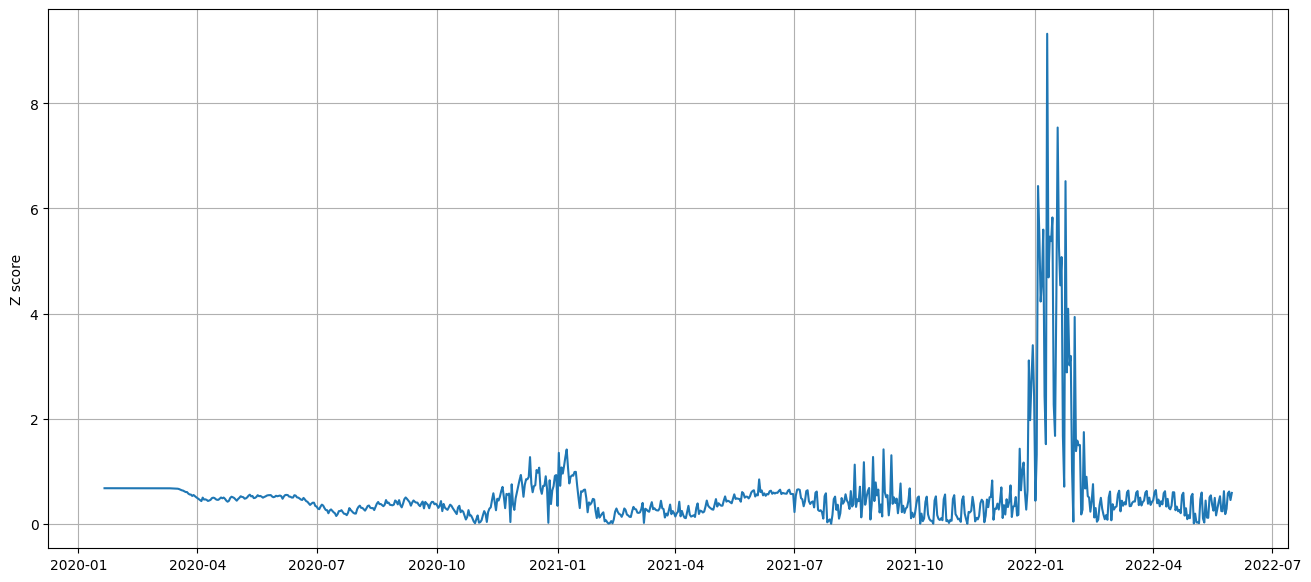

In [409]:
from scipy import stats
# calculate the absolute value of z-score
z_covid = np.abs(stats.zscore(covid_np))
print('z score of the (filled) covid dataset is:\r\n',z_covid)
plt.figure(figsize=(16,7))
plt.plot(covid_time_fill,z_covid)
plt.grid()
#plt.xlim([datetime.datetime(), end_date])
plt.ylabel('Z score')
plt.show()

In [410]:
stock_pre_nan

,Close
2017-04-01,NaN
2017-04-02,NaN
2017-04-03,33.718447
2017-04-04,33.969517
2017-04-05,33.793534
...,...
2022-05-27,148.995821
2022-05-28,NaN
2022-05-29,NaN
2022-05-30,NaN


In [411]:
weather_pre

,tavg,tmin,tmax,prcp,wspd
time,,,,,
2017-04-01,17.4,9.7,25.3,0.0,7.5
2017-04-02,16.8,10.3,24.7,0.0,10.2
2017-04-03,15.4,9.7,21.9,0.0,11.8
2017-04-04,15.2,7.5,23.0,0.0,8.7
2017-04-05,17.4,11.9,24.1,0.0,8.4
...,...,...,...,...,...
2022-05-27,17.0,13.6,21.9,0.0,14.9
2022-05-28,18.2,14.1,23.6,0.0,16.2
2022-05-29,16.9,12.5,23.0,0.0,17.9


In [412]:
covid_daily_pre_0

,daily_confirmed
date,
2020-01-21,0.0
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,1.0
...,...
2022-05-27,138911.0
2022-05-28,13762.0
2022-05-29,9045.0


['2017-04-03T00:00:00.000000000' '2017-04-04T00:00:00.000000000'
 '2017-04-05T00:00:00.000000000' ... '2022-05-26T00:00:00.000000000'
 '2022-05-27T00:00:00.000000000' '2022-05-31T00:00:00.000000000']
[ 33.71844731  33.96951717  33.79353362 ... 143.16104708 148.9958206
 148.19926449]
z score of the dataset is:
 [1.05800712 1.05252385 1.05636726 ... 1.33217418 1.45960323 1.44220677]


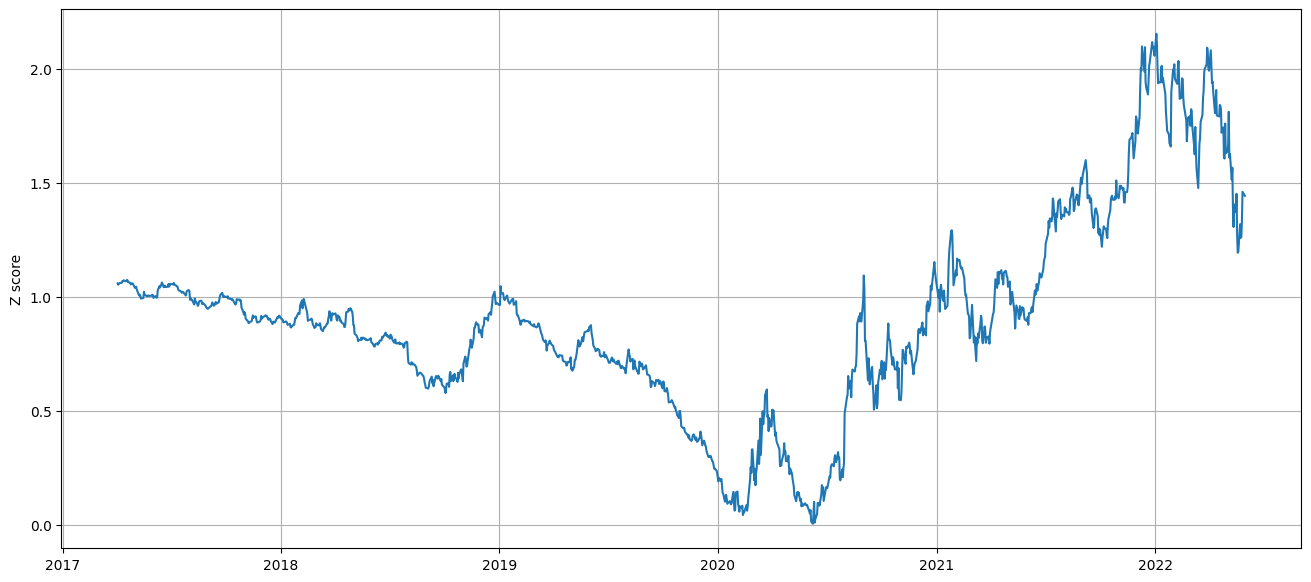

In [413]:
stock_np=stock_data[['Close']].to_numpy().flatten()
stock_time=stock_pre.index.values
print(stock_time)
# stock=stock.to_numpy().flatten()
print(stock_np)

z_stock = np.abs(stats.zscore(stock_np))
print('z score of the dataset is:\r\n',z_stock)
plt.figure(figsize=(16,7))
plt.plot(stock_time,z_stock)
plt.grid()
#plt.xlim([datetime.datetime(), end_date])
plt.ylabel('Z score')
plt.show()

In [414]:
stock_GOOG=stock_data_GOOG[['Close']]
stock_GOOG

,Close
date,
2017-04-03,41.9275
2017-04-04,41.7285
2017-04-05,41.5705
2017-04-06,41.3940
2017-04-07,41.2335
...,...
2022-05-24,105.9260
2022-05-25,105.8395
2022-05-26,108.2960


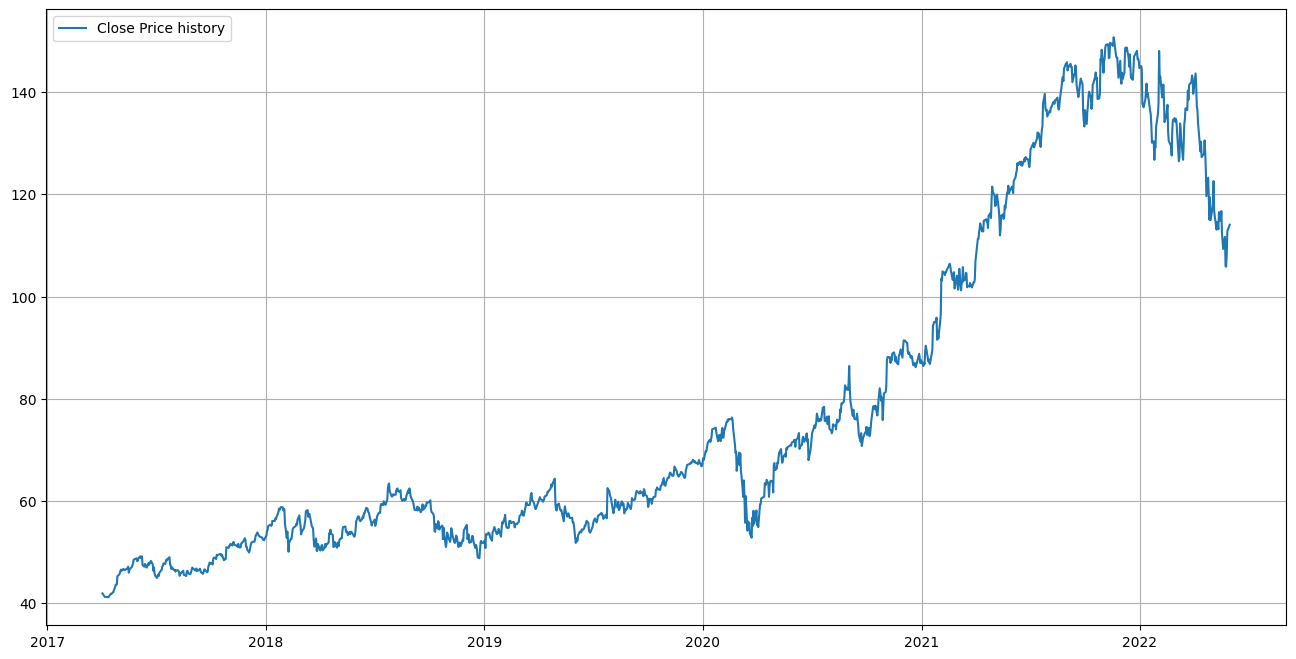

In [415]:
# df=pd.read_csv(stock_data)
# df['date'] = pd.to_datetime(df.date,format='%Y-%m-%d')
# df.index = df['date']
    
#plot price
price=stock_GOOG['Close']
plt.figure(figsize=(16,8))
plt.plot(price, label='Close Price history')
plt.legend()
plt.grid()
plt.savefig('price.jpg')


['2017-04-03T00:00:00.000000000' '2017-04-04T00:00:00.000000000'
 '2017-04-05T00:00:00.000000000' ... '2022-05-26T00:00:00.000000000'
 '2022-05-27T00:00:00.000000000' '2022-05-31T00:00:00.000000000']
[ 41.9275  41.7285  41.5705 ... 108.296  112.799  114.039 ]
[1.1229612  1.12911308 1.13399749 ... 0.92875333 1.06795899 1.10629232]
z score of the dataset is:
 [1.1229612  1.12911308 1.13399749 ... 0.92875333 1.06795899 1.10629232]


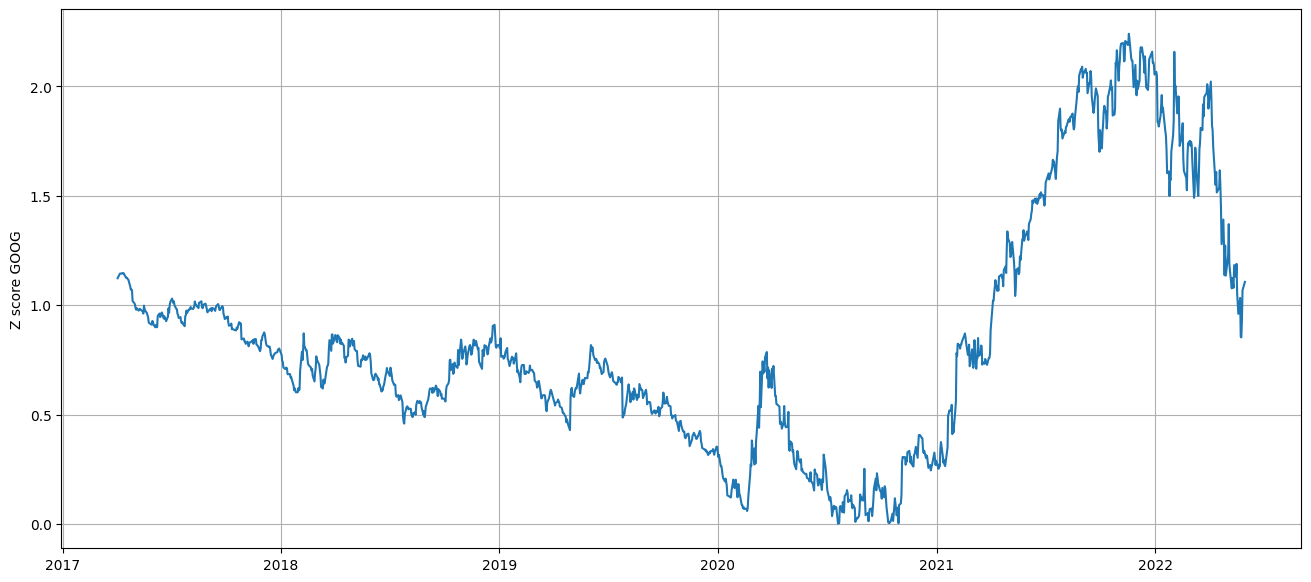

In [418]:
stock_GOOG_np=stock_data_GOOG[['Close']].to_numpy().flatten()
stock_time_GOOG=stock_pre_GOOG.index.values
print(stock_time_GOOG)
# stock=stock.to_numpy().flatten()
print(stock_GOOG_np)

z_stock_GOOG = np.abs(stats.zscore(stock_GOOG_np))
print(z_stock_GOOG)
print('z score of the dataset is:\r\n',z_stock_GOOG)
plt.figure(figsize=(16,7))
plt.plot(stock_time_GOOG,z_stock_GOOG)
plt.grid()
#plt.xlim([datetime.datetime(), end_date])
plt.ylabel('Z score GOOG')
plt.show()

In [419]:
stock_data_GOOG

,Open,High,Low,Original Close,Close,Volume,Dividend,Split
date,,,,,,,,
2017-04-03,829.22,840.8500,829.2200,838.55,41.9275,1671503.0,0.0,1.0
2017-04-04,831.36,835.1800,829.0363,834.57,41.7285,1045363.0,0.0,1.0
2017-04-05,835.51,842.4500,830.7200,831.41,41.5705,1555328.0,0.0,1.0
2017-04-06,832.40,836.3900,826.4600,827.88,41.3940,1254433.0,0.0,1.0
2017-04-07,827.96,828.4850,820.5127,824.67,41.2335,1056692.0,0.0,1.0
...,...,...,...,...,...,...,...,...
2022-05-24,2127.55,2127.9000,2044.1600,2118.52,105.9260,3019319.0,0.0,1.0
2022-05-25,2102.84,2130.8938,2084.2250,2116.79,105.8395,1894967.0,0.0,1.0
2022-05-26,2121.01,2179.1050,2109.7600,2165.92,108.2960,1514374.0,0.0,1.0


# Outlier

In [420]:
# set a threshold and find the location where the value meets our condition(s)
threshold = 3
covid_outlier_loc = np.where(z_covid > threshold)

# find the outlier value given its index
covid_outlier_by_Z_Score = z_covid[covid_outlier_loc]
print('the data classified as outlier by z score:\r\n', covid_outlier_by_Z_Score)
print('the datetime of the outlier is:\r\n', covid_time_fill[covid_outlier_loc])

the data classified as outlier by z score:
 [3.11065588 3.40025127 6.42685971 5.49889186 4.23042008 4.61515679
 5.59839297 9.32206028 4.68986633 5.4645436  5.37891712 5.82967865
 4.28613485 7.5392576  5.26206051 4.53913582 5.07622837 6.51910612
 4.09357118 3.01804674 3.19600334 3.93679972]
the datetime of the outlier is:
 ['2021-12-27T00:00:00.000000000' '2021-12-30T00:00:00.000000000'
 '2022-01-03T00:00:00.000000000' '2022-01-04T00:00:00.000000000'
 '2022-01-05T00:00:00.000000000' '2022-01-06T00:00:00.000000000'
 '2022-01-07T00:00:00.000000000' '2022-01-10T00:00:00.000000000'
 '2022-01-11T00:00:00.000000000' '2022-01-12T00:00:00.000000000'
 '2022-01-13T00:00:00.000000000' '2022-01-14T00:00:00.000000000'
 '2022-01-17T00:00:00.000000000' '2022-01-18T00:00:00.000000000'
 '2022-01-19T00:00:00.000000000' '2022-01-20T00:00:00.000000000'
 '2022-01-21T00:00:00.000000000' '2022-01-24T00:00:00.000000000'
 '2022-01-26T00:00:00.000000000' '2022-01-27T00:00:00.000000000'
 '2022-01-28T00:00:00.0000

# no outlier for GOOG stock; just for check correlation

In [422]:
threshold = 3
GOOG_outlier_loc = np.where(z_stock_GOOG > threshold)

# find the outlier value given its index
GOOG_outlier_by_Z_Score = z_stock_GOOG[GOOG_outlier_loc]
print('the data classified as outlier by z score:\r\n', GOOG_outlier_by_Z_Score)
print('the datetime of the outlier is:\r\n', stock_time_GOOG[GOOG_outlier_loc])

the data classified as outlier by z score:
 []
the datetime of the outlier is:
 []


# Box Plot

[ 33.71844731  33.96951717  33.79353362 ... 143.16104708 148.9958206
 148.19926449]
['2017-04-03T00:00:00.000000000' '2017-04-04T00:00:00.000000000'
 '2017-04-05T00:00:00.000000000' ... '2022-05-26T00:00:00.000000000'
 '2022-05-27T00:00:00.000000000' '2022-05-31T00:00:00.000000000']


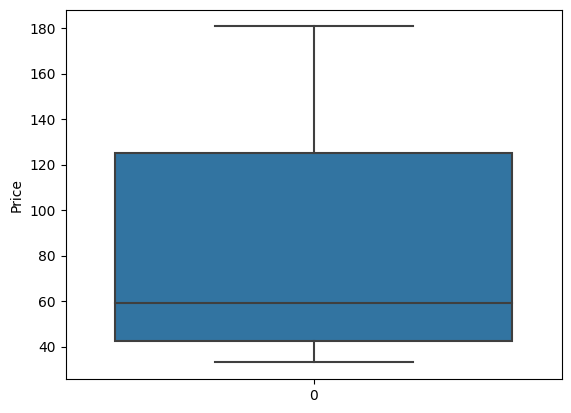

In [423]:
import seaborn as sns

# extract all the data except the last one because it is a NaN, which is missing value. 
# We will see shortly how to deal with missing value.
outlier_dataset_stock = stock_np
print(outlier_dataset_stock)
#print('\n')
outlier_date_stock = np.array(stock_time)
print(outlier_date_stock)
# box plot
sns.boxplot(outlier_dataset_stock)
plt.ylabel(r'Price')
plt.show()

[ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00
  2.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00
  1.000000e+00  1.000000e+00  3.000000e+00  0.000000e+00  0.000000e+00
  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
  1.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00
  0.000000e+00  0.000000e+00  1.000000e+01  0.000000e+00  0.000000e+00
  2.000000e+00  3.000000e+00  0.000000e+00  0.000000e+00  1.300000e+01
  2.000000e+00  1.500000e+01  0.000000e+00  5.000000e+00  5.000000e+00
  1.800000e+01  1.600000e+01  2.100000e+01  3.600000e+01  6.700000e+01
  8.300000e+01  1.170000e+02  1.190000e+02  2.010000e+02  2.700000e+02
  2.450000e+02  4.050000e+02  5.560000e+02  6.740000e+02  7.020000e+02
  9.070000e+02  1.399000e+03  2.444000e+03  4.043000e+03  5.619000e+03
  6.516000e+03  8.545000e+03  1.043200e+04  1.043300e+04  1.463400e+04
  1.699800e+04  1.733000e+04  2.106600e+04  1.852000e+04  2.146900e+04
  2.45

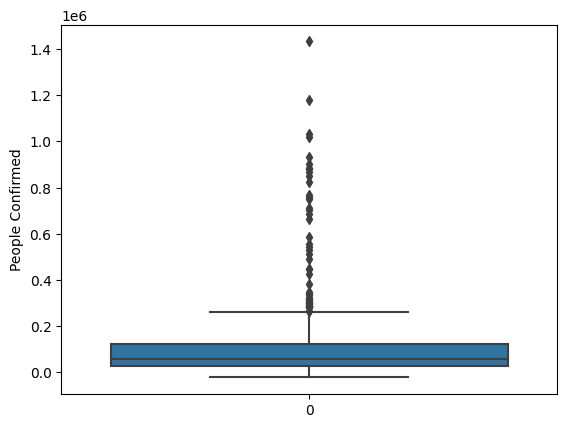

In [424]:
import seaborn as sns
# extract all the data except the last one because it is a NaN, which is missing value. 
# We will see shortly how to deal with missing value.
outlier_dataset_covid = covid_np
print(outlier_dataset_covid)
#print('\n')
outlier_date_covid = covid_time_fill
print(outlier_date_covid)
# box plot
sns.boxplot(outlier_dataset_covid)
plt.ylabel(r'People Confirmed')
plt.show()

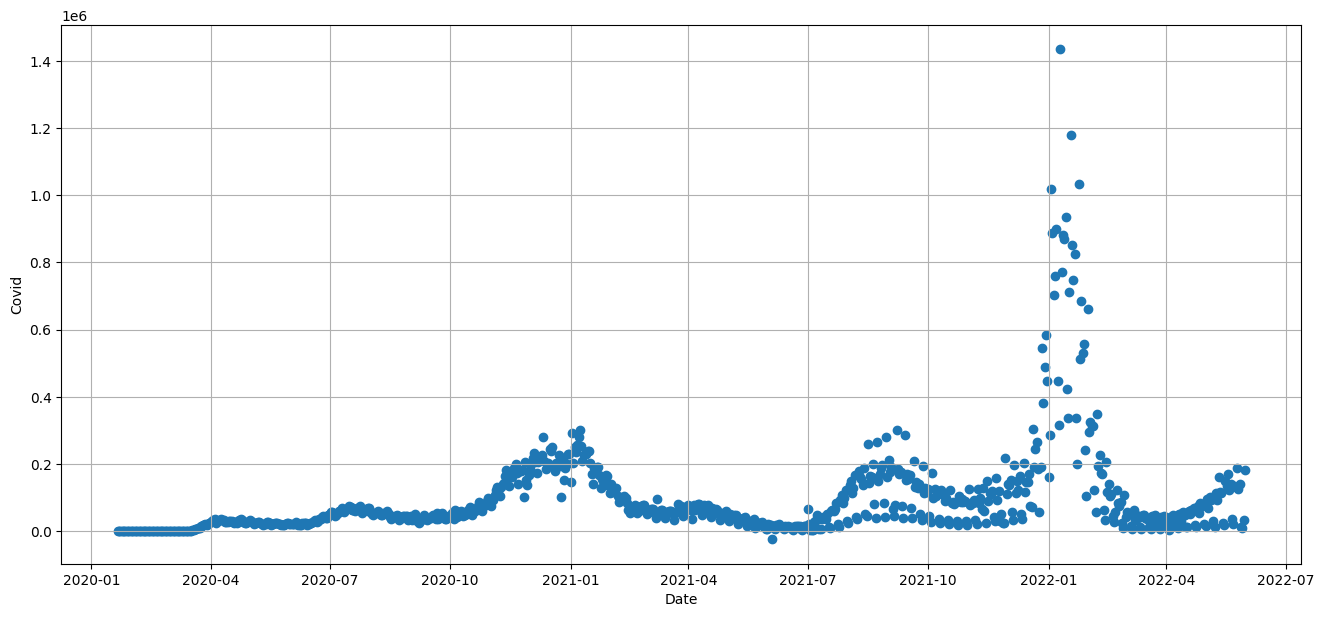

In [425]:
plt.figure(figsize=(16,7))
plt.scatter(outlier_date_covid,outlier_dataset_covid)
plt.xlabel('Date')
plt.ylabel('Covid')
plt.grid()
plt.show()

# Cap

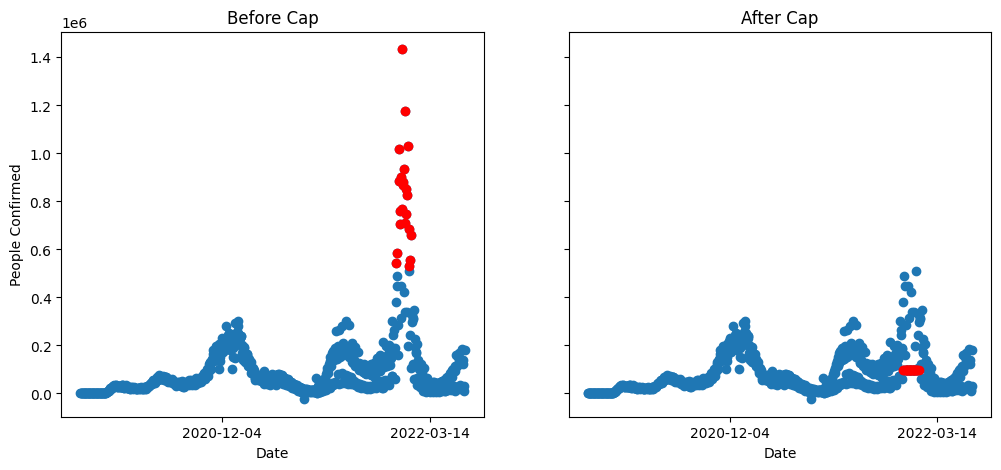

In [426]:
capped_outlier_dataset = np.copy(outlier_dataset_covid)
capped_outlier_dataset[covid_outlier_loc] = np.mean(capped_outlier_dataset)


# Plot and compare, before and after the outlier is capped.
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(12, 5))
ax1.set_title("Before Cap")
ax1.scatter(outlier_date_covid, outlier_dataset_covid)
ax1.scatter(outlier_date_covid[covid_outlier_loc], outlier_dataset_covid[covid_outlier_loc], c = 'r')
ax1.set_xlabel("Date")
ax1.set_ylabel("People Confirmed")
ax1.xaxis.set_major_locator(MultipleLocator(465)) # Spacing of axis tickers.

ax2.set_title("After Cap")
ax2.scatter(outlier_date_covid, capped_outlier_dataset)
ax2.scatter(outlier_date_covid[covid_outlier_loc], capped_outlier_dataset[covid_outlier_loc], c = 'r')
ax2.set_xlabel("Date")
ax2.xaxis.set_major_locator(MultipleLocator(465)) # Spacing of axis tickers.

# Merge

In [427]:
covid_pre_nan

,confirmed,daily_confirmed
2017-04-01,NaN,NaN
2017-04-02,NaN,NaN
2017-04-03,NaN,NaN
2017-04-04,NaN,NaN
2017-04-05,NaN,NaN
...,...,...
2022-05-27,83903655.0,138911.0
2022-05-28,83917417.0,13762.0
2022-05-29,83926462.0,9045.0
2022-05-30,83958614.0,32152.0


In [428]:
weather_pre

,tavg,tmin,tmax,prcp,wspd
time,,,,,
2017-04-01,17.4,9.7,25.3,0.0,7.5
2017-04-02,16.8,10.3,24.7,0.0,10.2
2017-04-03,15.4,9.7,21.9,0.0,11.8
2017-04-04,15.2,7.5,23.0,0.0,8.7
2017-04-05,17.4,11.9,24.1,0.0,8.4
...,...,...,...,...,...
2022-05-27,17.0,13.6,21.9,0.0,14.9
2022-05-28,18.2,14.1,23.6,0.0,16.2
2022-05-29,16.9,12.5,23.0,0.0,17.9


In [429]:
stock_pre_nan = stock_pre_nan.rename(columns={'Close':'AAPL Close'})
stock_pre_nan

,AAPL Close
2017-04-01,NaN
2017-04-02,NaN
2017-04-03,33.718447
2017-04-04,33.969517
2017-04-05,33.793534
...,...
2022-05-27,148.995821
2022-05-28,NaN
2022-05-29,NaN
2022-05-30,NaN


# Apple Stock statstic properties

In [430]:
AAPL_stock_max=stock_pre['Close'].max()
print(AAPL_stock_max)
AAPL_stock_std=stock_pre['Close'].std()
print(AAPL_stock_std)
AAPL_stock_min=stock_pre['Close'].min()
print(AAPL_stock_min)
AAPL_stock_mean=stock_pre['Close'].mean()
print(AAPL_stock_mean)
AAPL_stock_median=stock_pre['Close'].median()
print(AAPL_stock_median)
AAPL_stock_size=stock_pre.shape[0]
print(AAPL_stock_size)

180.731196031125
45.80603054549046
33.0098202319834
82.16291032921649
59.3307379237486
1300


# GOOG Stock statistic properties

In [431]:
GOOG_stock_max=stock_pre_GOOG['Close'].max()
print(GOOG_stock_max)
GOOG_stock_std=stock_pre_GOOG['Close'].std()
print(GOOG_stock_std)
GOOG_stock_min=stock_pre_GOOG['Close'].min()
print(GOOG_stock_min)
GOOG_stock_mean=stock_pre_GOOG['Close'].mean()
print(GOOG_stock_mean)
GOOG_stock_median=stock_pre_GOOG['Close'].median()
print(GOOG_stock_median)
GOOG_stock_size=stock_pre_GOOG.shape[0]
print(GOOG_stock_size)


150.709
32.36027238881466
41.1675
78.25285096153846
62.1255
1300


# Covid Data statistic properties

In [432]:
covid_max=covid_daily_pre['daily_confirmed'].max()
print(covid_max)
covid_std=covid_daily_pre['daily_confirmed'].std()
print(covid_std)
covid_min=covid_daily_pre['daily_confirmed'].min()
print(covid_min)
covid_mean=covid_daily_pre['daily_confirmed'].mean()
print(covid_mean)
covid_median=covid_daily_pre['daily_confirmed'].median()
print(covid_median)
covid_size=covid_daily_pre.shape[0]
print(covid_size)

1433977.0
143438.4057964699
-23999.0
97611.36426914153
54684.5
862


In [435]:
covid_min=covid_daily_pre['daily_confirmed'].min()
print(covid_min)

-23999.0


In [436]:
stock_pre_nan_GOOG= stock_pre_nan_GOOG.rename(columns={'Close':'GOOG Close'})
stock_pre_nan_GOOG

,GOOG Close
2017-04-01,NaN
2017-04-02,NaN
2017-04-03,41.9275
2017-04-04,41.7285
2017-04-05,41.5705
...,...
2022-05-27,112.7990
2022-05-28,NaN
2022-05-29,NaN
2022-05-30,NaN


In [437]:
covid_pre_nan

,confirmed,daily_confirmed
2017-04-01,NaN,NaN
2017-04-02,NaN,NaN
2017-04-03,NaN,NaN
2017-04-04,NaN,NaN
2017-04-05,NaN,NaN
...,...,...
2022-05-27,83903655.0,138911.0
2022-05-28,83917417.0,13762.0
2022-05-29,83926462.0,9045.0
2022-05-30,83958614.0,32152.0


In [438]:
covid_daily_pre

,daily_confirmed
date,
2020-01-21,0.0
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,1.0
...,...
2022-05-27,138911.0
2022-05-28,13762.0
2022-05-29,9045.0


In [439]:
new2 = pd.concat([stock_pre_nan, stock_pre_nan_GOOG,covid_pre_confirmed,covid_daily_pre, weather_pre], axis=1, join='outer')
new2

,AAPL Close,GOOG Close,confirmed,daily_confirmed,tavg,tmin,tmax,prcp,wspd
2017-04-01,NaN,NaN,NaN,NaN,17.4,9.7,25.3,0.0,7.5
2017-04-02,NaN,NaN,NaN,NaN,16.8,10.3,24.7,0.0,10.2
2017-04-03,33.718447,41.9275,NaN,NaN,15.4,9.7,21.9,0.0,11.8
2017-04-04,33.969517,41.7285,NaN,NaN,15.2,7.5,23.0,0.0,8.7
2017-04-05,33.793534,41.5705,NaN,NaN,17.4,11.9,24.1,0.0,8.4
...,...,...,...,...,...,...,...,...,...
2022-05-27,148.995821,112.7990,83903655.0,138911.0,17.0,13.6,21.9,0.0,14.9
2022-05-28,NaN,NaN,83917417.0,13762.0,18.2,14.1,23.6,0.0,16.2
2022-05-29,NaN,NaN,83926462.0,9045.0,16.9,12.5,23.0,0.0,17.9
2022-05-30,NaN,NaN,83958614.0,32152.0,16.6,11.4,24.1,0.0,16.1


# Correlation - EDA

- Normalization:
当数据集中不同特征项的范围相差较大时，必须要进行归一化处理，否则目标函数的图像会变“扁”，梯度下降时会走很多弯路。

In [505]:
new2_norm = (new2- new2.mean()) / (new2.std())

<AxesSubplot: >

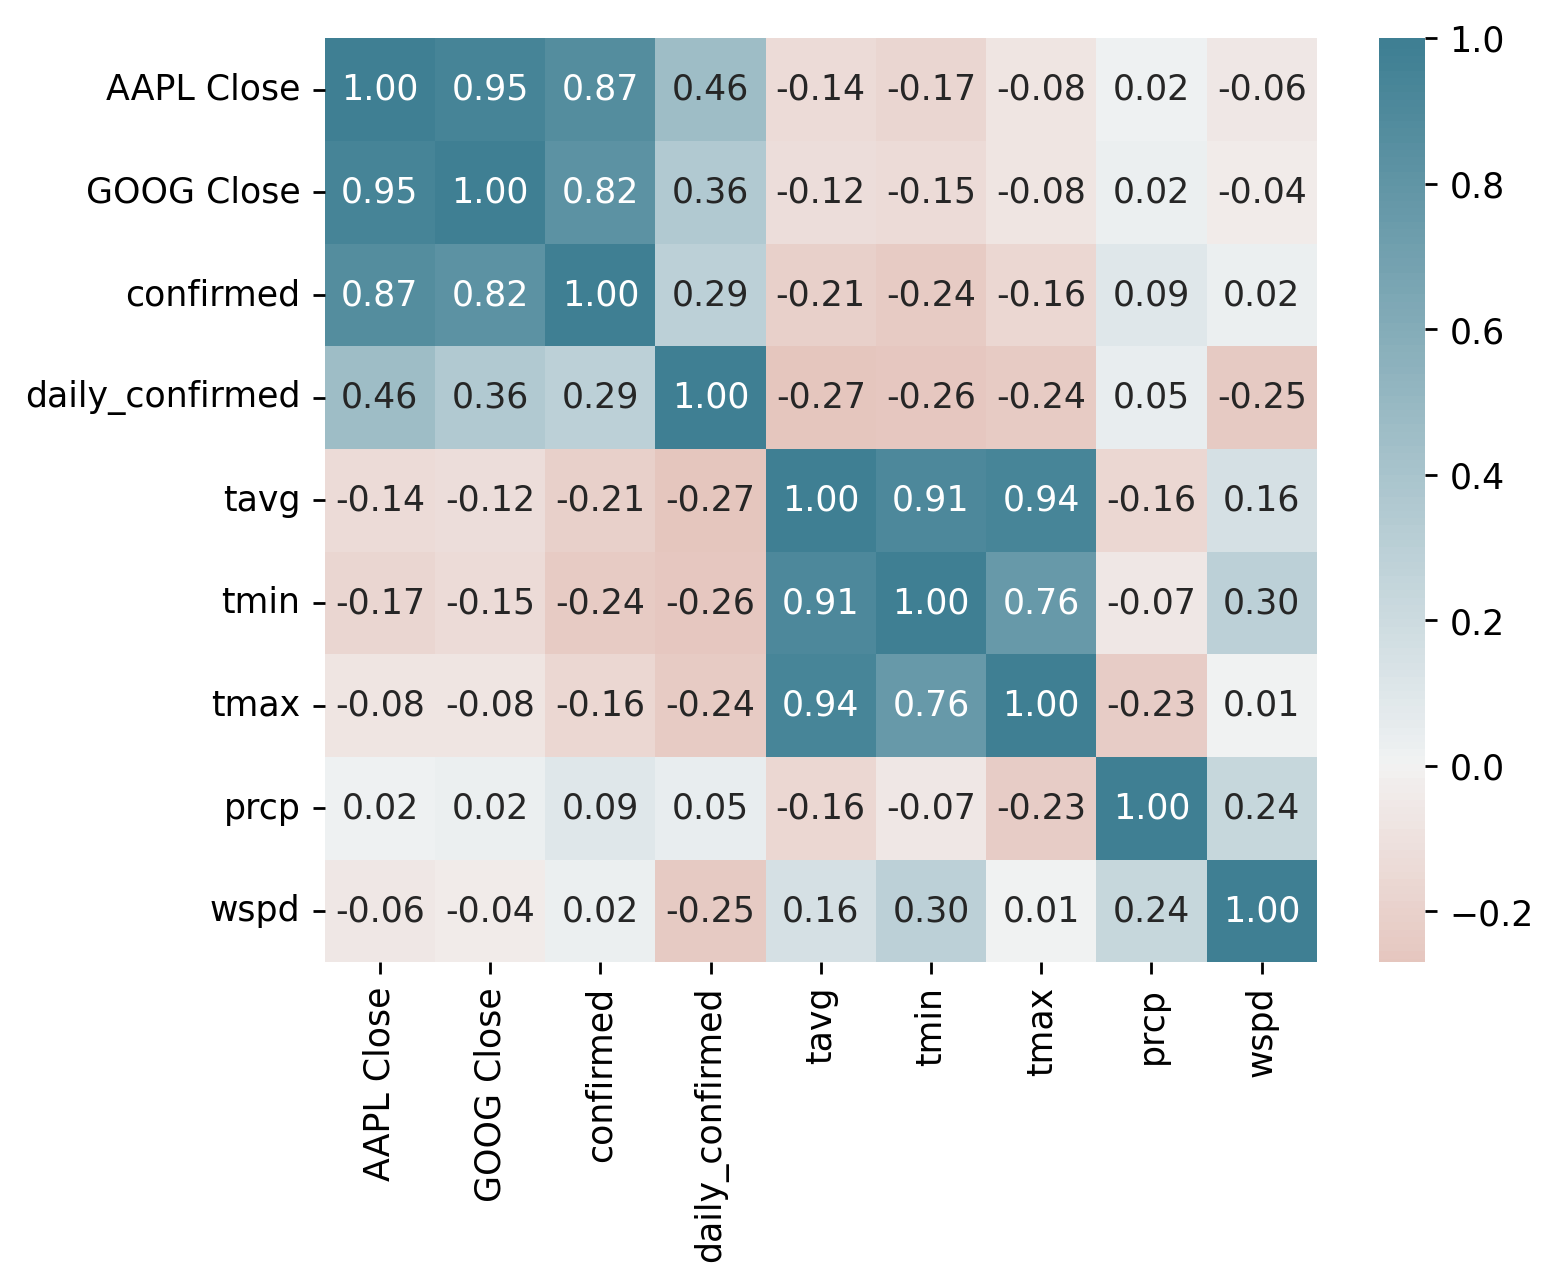

In [441]:
plt.figure(dpi=250)
sns.heatmap(new2_norm.corr(), 
            cmap=sns.diverging_palette(20, 220, n=200), 
            annot=True, # 注入数据
            fmt='.2f',   # 字符串格式代码
            center = 0,  # 绘制有色数据时将色彩映射居中的值
           )

<AxesSubplot: >

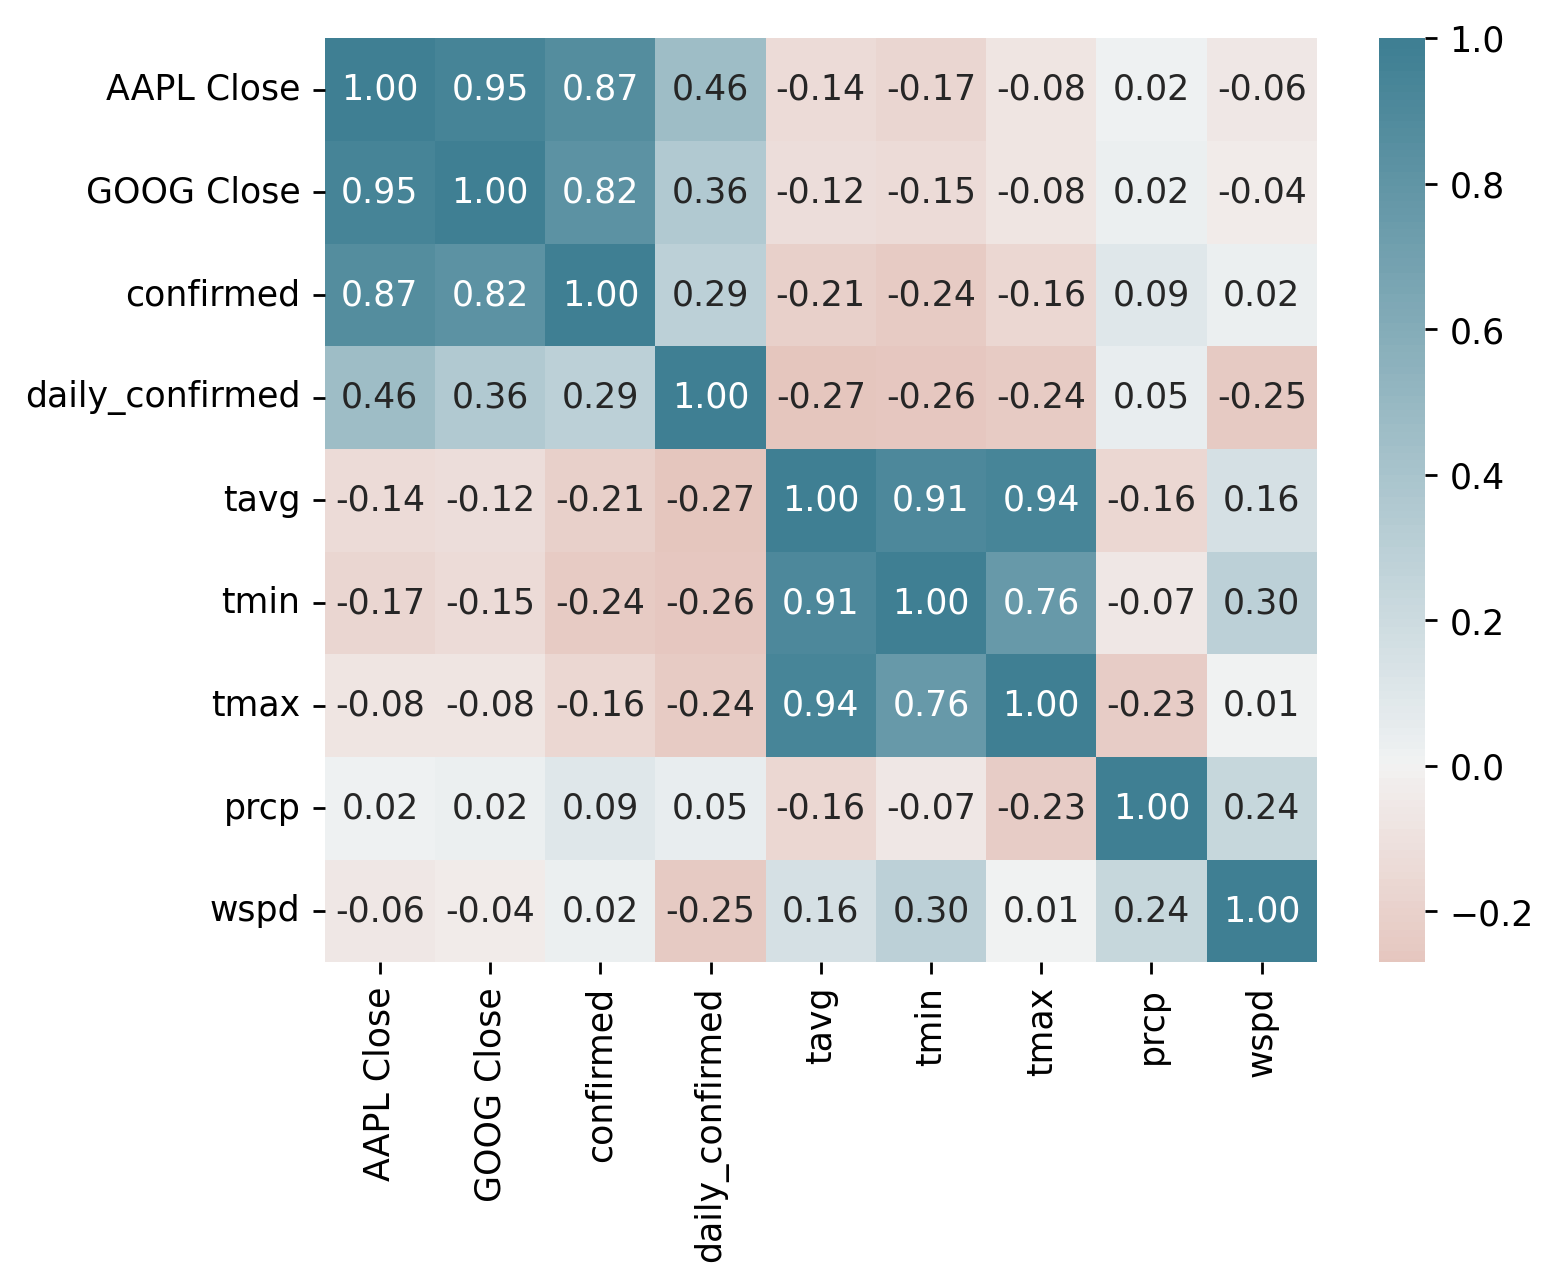

In [442]:
plt.figure(dpi=250)
sns.heatmap(new2.corr(), 
            cmap=sns.diverging_palette(20, 220, n=200), 
            annot=True, # 注入数据
            fmt='.2f',   # 字符串格式代码
            center = 0,  # 绘制有色数据时将色彩映射居中的值
           )

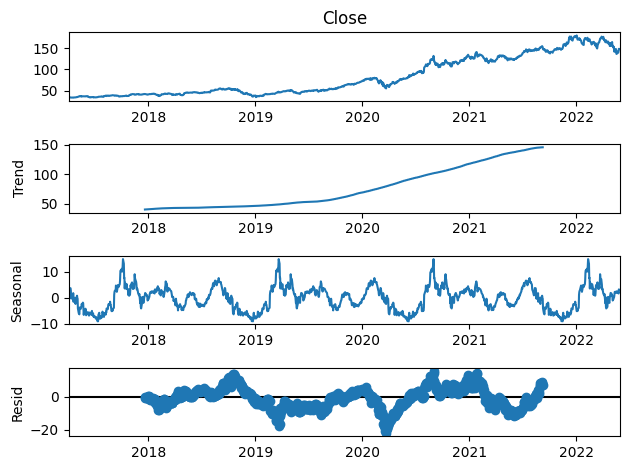

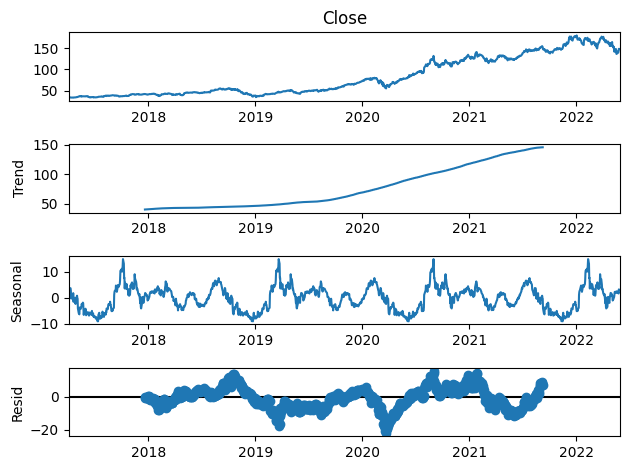

In [443]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(stock_pre['Close'] ,model='addictive', period=365)
decomposition.plot()

# Hypothesis Test

- It is obvious that Google Close and Covid Daily Confirmed cases are strongly correlated with the APPL Close. Weather data can be discarded.

In [444]:
from numpy import sqrt, abs, round
from scipy.stats import norm

- z-statistic

双样本Z检验用于比较两组数据均值进行差异对比或两组样本的均值差值与数字对比，一般用于大样本（即样本容量大于30）的平均值差异性检验的方法。它是用标准正态分布的理论推断差异发生的概率，从而比较两个平均值的差异是否显著。

In [445]:
def two_samples_t_test(mean1, mean2, sigma1, sigma2, size1, size2, significance_level=0.05, test=0):
    """
    Executes a two sample T-test with the statistic properties passed.

    :param mean1: mean of the first sample.
    :param mean2: mean of the second sample.
    :param sigma1: standard deviation of the first sample.
    :param sigma2: standard deviation of the second sample.
    :param size1: size of the first sample.
    :param size2: size of the second sample.
    :param significance_level: superior limit of the p-value to reject H0. default_value=0.05
    :param test: define the test to execute. 0 means two tails two samples T-test; 1 means one tail two samples T-test;
        any other value means a one tail two samples T-test on the other side. default_value=0
    :return:
    """
    # Compute Z-statistic
    overall_sigma = sqrt(sigma1 ** 2 / size1 + sigma2 ** 2 / size2)
    z_statistic = round((mean1 - mean2) / overall_sigma, 5)
    # Compute p-value from Z-statistic
    if test == 0:
        # Two tails -> H0:x1=x2 H1:x1!=x2
        print('Two Tails test. H0 is x1=x2 and H1 is x1!=x2')
        p_value = round(2 * (1 - norm.cdf(abs(z_statistic))), 5)
    elif test == 1:
        # One tail right -> H0:x1>x2 H1:x1<=x2
        print('One Tail test. H0 is x1>x2 and H1 is x1<=x2')
        p_value = round((1 - norm.cdf(z_statistic)), 5)
    else:
        # One tail left -> H0:x1<x2 H1:x1>=x2
        print('One Tail test. H0 is x1<x2 and H1 is x1>=x2')
        p_value = round((norm.cdf(z_statistic)), 5)
    # Reject or not the Null hypothesis
    if p_value < significance_level:
        print(f'Statistic:{z_statistic} - P-value:{p_value} - Reject Null Hypothesis')
    else:
        print(f'Statistic:{z_statistic} - P-value:{p_value} - Do Not Reject Null Hypothesis')


In [446]:
#输入是numpy array； 关于统计值
two_samples_t_test(GOOG_stock_mean, AAPL_stock_mean, GOOG_stock_std, AAPL_stock_std,GOOG_stock_size, AAPL_stock_size)


Two Tails test. H0 is x1=x2 and H1 is x1!=x2
Statistic:-2.51373 - P-value:0.01195 - Reject Null Hypothesis


In [447]:
two_samples_t_test(GOOG_stock_mean, AAPL_stock_mean, GOOG_stock_std, AAPL_stock_std,GOOG_stock_size, AAPL_stock_size)

Two Tails test. H0 is x1=x2 and H1 is x1!=x2
Statistic:-2.51373 - P-value:0.01195 - Reject Null Hypothesis


In [448]:
two_samples_t_test(covid_mean, AAPL_stock_mean, covid_std, AAPL_stock_std,covid_size, AAPL_stock_size)

Two Tails test. H0 is x1=x2 and H1 is x1!=x2
Statistic:19.96286 - P-value:0.0 - Reject Null Hypothesis


# Data Inference

In [449]:
from fbprophet import Prophet

In [450]:
stock_pre

,Close
date,
2017-04-03,33.718447
2017-04-04,33.969517
2017-04-05,33.793534
2017-04-06,33.709062
2017-04-07,33.633975
...,...
2022-05-24,139.755770
2022-05-25,139.915081
2022-05-26,143.161047


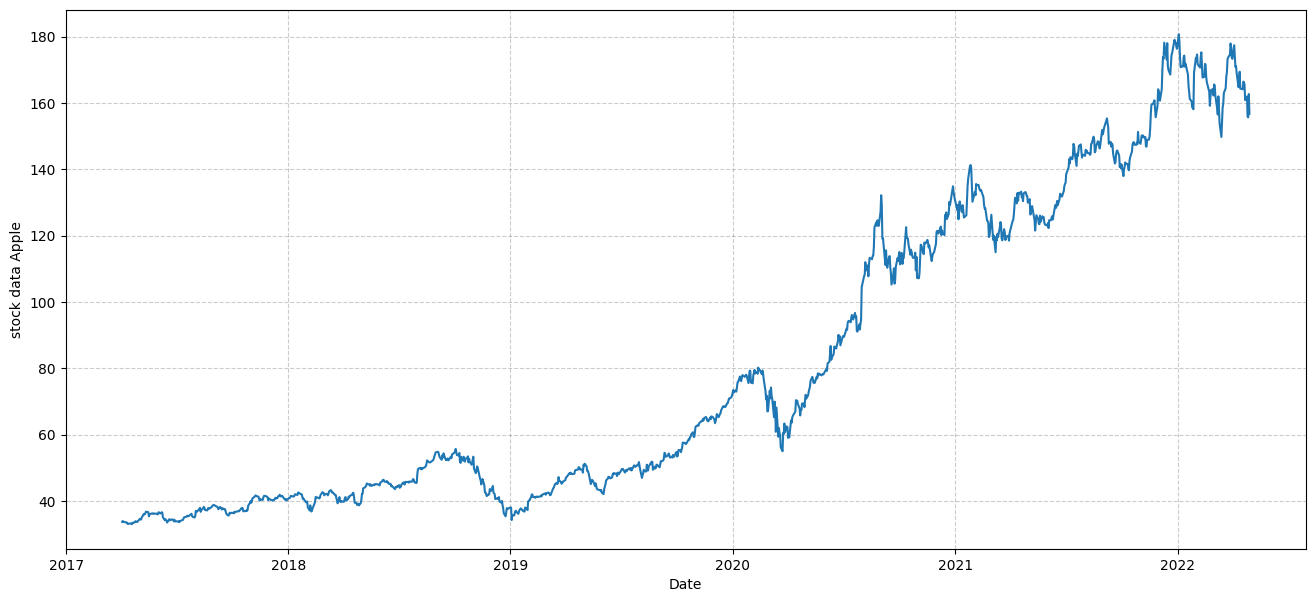

In [332]:
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(stock_pre)
ax.grid(ls='--', c='k', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('stock data Apple')
plt.show()

# Base Model

In [458]:
stock_pre

,Close
date,
2017-04-03,33.718447
2017-04-04,33.969517
2017-04-05,33.793534
2017-04-06,33.709062
2017-04-07,33.633975
...,...
2022-05-24,139.755770
2022-05-25,139.915081
2022-05-26,143.161047


In [497]:
def prepare_data(data, target_feature): 
    """
    prepare the data for ingestion by fbprophet: 
    see: https://facebook.github.io/prophet/docs/quick_start.html
    """
    new_data = data.copy()
    new_data.reset_index(inplace=True)
    new_data = new_data.rename({'index':'ds', '{}'.format(target_feature):'y'}, axis=1)
    
    return new_data

In [495]:
stock_pre_nan

,AAPL Close
2017-04-01,NaN
2017-04-02,NaN
2017-04-03,33.718447
2017-04-04,33.969517
2017-04-05,33.793534
...,...
2022-05-27,148.995821
2022-05-28,NaN
2022-05-29,NaN
2022-05-30,NaN


In [499]:
stock_aapl = prepare_data(data=stock_pre_nan, target_feature='AAPL Close')
stock_aapl

,ds,y
0,2017-04-01,NaN
1,2017-04-02,NaN
2,2017-04-03,33.718447
3,2017-04-04,33.969517
4,2017-04-05,33.793534
...,...,...
1882,2022-05-27,148.995821
1883,2022-05-28,NaN
1884,2022-05-29,NaN
1885,2022-05-30,NaN


# train test split and model fit

In [501]:
def train_test_split(data):
    
    
    train = data.set_index('ds').loc[:'2022-04-30', :].reset_index()
    test = data.set_index('ds').loc['2022-05-01':, :].reset_index()
    
    return train, test

In [502]:
train, test=train_test_split(data=stock_aapl)

In [503]:
train

,ds,y
0,2017-04-01,NaN
1,2017-04-02,NaN
2,2017-04-03,33.718447
3,2017-04-04,33.969517
4,2017-04-05,33.793534
...,...,...
1851,2022-04-26,155.897020
1852,2022-04-27,155.668345
1853,2022-04-28,162.697630
1854,2022-04-29,156.742125


In [507]:
test

,ds,y
0,2022-05-01,NaN
1,2022-05-02,157.050340
2,2022-05-03,158.561587
3,2022-05-04,165.063924
4,2022-05-05,155.867193
5,2022-05-06,156.602931
6,2022-05-07,NaN
7,2022-05-08,NaN
8,2022-05-09,151.405403
9,2022-05-10,153.844856


In [541]:
m = Prophet(seasonality_mode='multiplicative',
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=False)

In [542]:
m.fit(train)

Initial log joint probability = -12.1185
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3590.56     0.0593056        427.27       1.117      0.1117      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3684.74     0.0181931       368.909           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3740.16     0.0326141       1373.16      0.1439      0.2671      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3762.95    0.00825432       1249.42           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3789.85     0.0130124        1123.9           1           1      584   
    Iter      log prob        ||dx||      ||grad||       alpha  

33.74   4.22862e-06       142.407   9.816e-08       0.001     8850  LS failed, Hessian reset 
    5930       3933.77   1.03407e-05       225.247   2.149e-07       0.001     8938  LS failed, Hessian reset 
    5937       3933.77   8.60948e-07       54.7154   8.495e-09       0.001     8996  LS failed, Hessian reset 
    5999        3933.8   6.06272e-05       450.288       0.561       0.561     9083   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    6099       3933.89   9.56686e-06       362.669     0.07461      0.9585     9223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    6199       3934.96     0.0025723       1225.56           1           1     9351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    6299       3936.05     0.0111574       1951.02           1           1     9466   
    Iter      log prob        ||dx||      ||grad||       alp

In [543]:
len(test)

31

In [544]:
future=m.make_future_dataframe(periods=30,freq='1D')
future

,ds
0,2017-04-01
1,2017-04-02
2,2017-04-03
3,2017-04-04
4,2017-04-05
...,...
1881,2022-05-26
1882,2022-05-27
1883,2022-05-28
1884,2022-05-29


In [545]:
forecast=m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2017-04-01,6.475351,-66.688968,-55.553818,6.475351,6.475351,-10.419951,-10.419951,-10.419951,-10.419951,-10.419951,-10.419951,0.0,0.0,0.0,-60.997492
1,2017-04-02,6.480263,-67.012857,-55.614570,6.480263,6.480263,-10.419951,-10.419951,-10.419951,-10.419951,-10.419951,-10.419951,0.0,0.0,0.0,-61.043760
2,2017-04-03,6.485175,27.342695,39.337316,6.485175,6.485175,4.158697,4.158697,4.158697,4.158697,4.158697,4.158697,0.0,0.0,0.0,33.455049
3,2017-04-04,6.490087,27.176662,39.299170,6.490087,6.490087,4.176242,4.176242,4.176242,4.176242,4.176242,4.176242,0.0,0.0,0.0,33.594258
4,2017-04-05,6.494998,27.889912,39.627373,6.494998,6.494998,4.179519,4.179519,4.179519,4.179519,4.179519,4.179519,0.0,0.0,0.0,33.640968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,2022-05-26,34.670265,172.896183,185.385531,34.576981,34.771025,4.168875,4.168875,4.168875,4.168875,4.168875,4.168875,0.0,0.0,0.0,179.206260
1882,2022-05-27,34.695206,172.819702,184.770868,34.582469,34.805463,4.156570,4.156570,4.156570,4.156570,4.156570,4.156570,0.0,0.0,0.0,178.908246
1883,2022-05-28,34.720146,-333.782892,-320.479656,34.592899,34.845296,-10.419951,-10.419951,-10.419951,-10.419951,-10.419951,-10.419951,0.0,0.0,0.0,-327.062073
1884,2022-05-29,34.745086,-333.594797,-320.419255,34.608096,34.879727,-10.419951,-10.419951,-10.419951,-10.419951,-10.419951,-10.419951,0.0,0.0,0.0,-327.297009


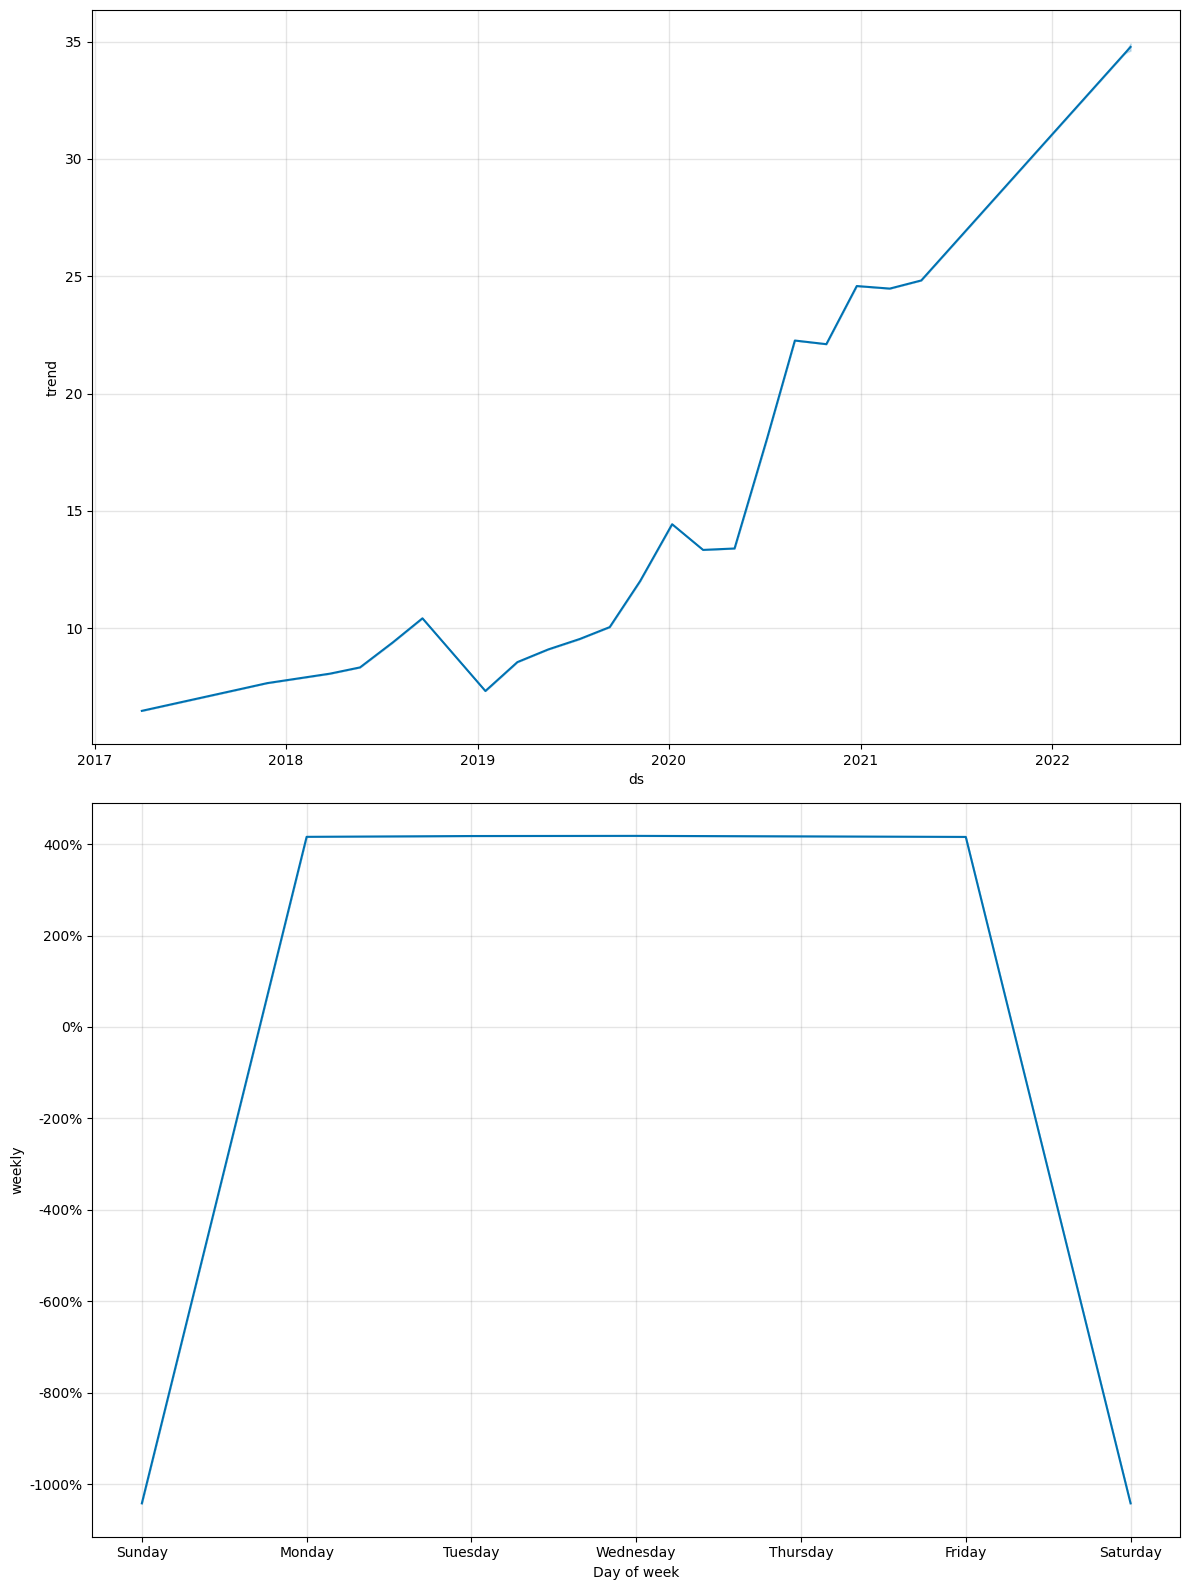

In [554]:
f = m.plot_components(forecast, figsize=(12, 16))

In [547]:
def make_predictions_df(forecast, data_train, data_test): 
    """
    Function to convert the output Prophet dataframe to a datetime index and append the actual target values at the end
    """
    forecast.index = pd.to_datetime(forecast.ds)
    data_train.index = pd.to_datetime(data_train.ds)
    data_test.index = pd.to_datetime(data_test.ds)
    data = pd.concat([data_train, data_test], axis=0)
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

def plot_predictions(forecast, start_date):
    """
    Function to plot the predictions 
    """
    f, ax = plt.subplots(figsize=(14, 8))
    
    train = forecast.loc[start_date:'2022-05-01',:]
    ax.plot(train.index, train.y, 'ko', markersize=3)
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = forecast.loc['2022-05-01':,:]
    ax.plot(test.index, test.y, 'ro', markersize=3)
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    ax.axvline(forecast.loc['2022-05-01', 'ds'], color='k', ls='--', alpha=0.7)

    ax.grid(ls=':', lw=0.5)
    
    return f, ax


In [548]:
result = make_predictions_df(forecast, train, test)
result.loc[:,'yhat'] = result.yhat.clip(lower=0)
result.loc[:,'yhat_lower'] = result.yhat_lower.clip(lower=0)
result.loc[:, 'yhat_upper'] = result.yhat_upper.clip(lower=0)
result

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,
2017-04-01,2017-04-01,6.475351,0.000000,0.000000,6.475351,6.475351,-10.419951,-10.419951,-10.419951,-10.419951,-10.419951,-10.419951,0.0,0.0,0.0,0.000000,NaN
2017-04-02,2017-04-02,6.480263,0.000000,0.000000,6.480263,6.480263,-10.419951,-10.419951,-10.419951,-10.419951,-10.419951,-10.419951,0.0,0.0,0.0,0.000000,NaN
2017-04-03,2017-04-03,6.485175,27.342695,39.337316,6.485175,6.485175,4.158697,4.158697,4.158697,4.158697,4.158697,4.158697,0.0,0.0,0.0,33.455049,33.718447
2017-04-04,2017-04-04,6.490087,27.176662,39.299170,6.490087,6.490087,4.176242,4.176242,4.176242,4.176242,4.176242,4.176242,0.0,0.0,0.0,33.594258,33.969517
2017-04-05,2017-04-05,6.494998,27.889912,39.627373,6.494998,6.494998,4.179519,4.179519,4.179519,4.179519,4.179519,4.179519,0.0,0.0,0.0,33.640968,33.793534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-26,2022-05-26,34.670265,172.896183,185.385531,34.576981,34.771025,4.168875,4.168875,4.168875,4.168875,4.168875,4.168875,0.0,0.0,0.0,179.206260,143.161047
2022-05-27,2022-05-27,34.695206,172.819702,184.770868,34.582469,34.805463,4.156570,4.156570,4.156570,4.156570,4.156570,4.156570,0.0,0.0,0.0,178.908246,148.995821
2022-05-28,2022-05-28,34.720146,0.000000,0.000000,34.592899,34.845296,-10.419951,-10.419951,-10.419951,-10.419951,-10.419951,-10.419951,0.0,0.0,0.0,0.000000,NaN


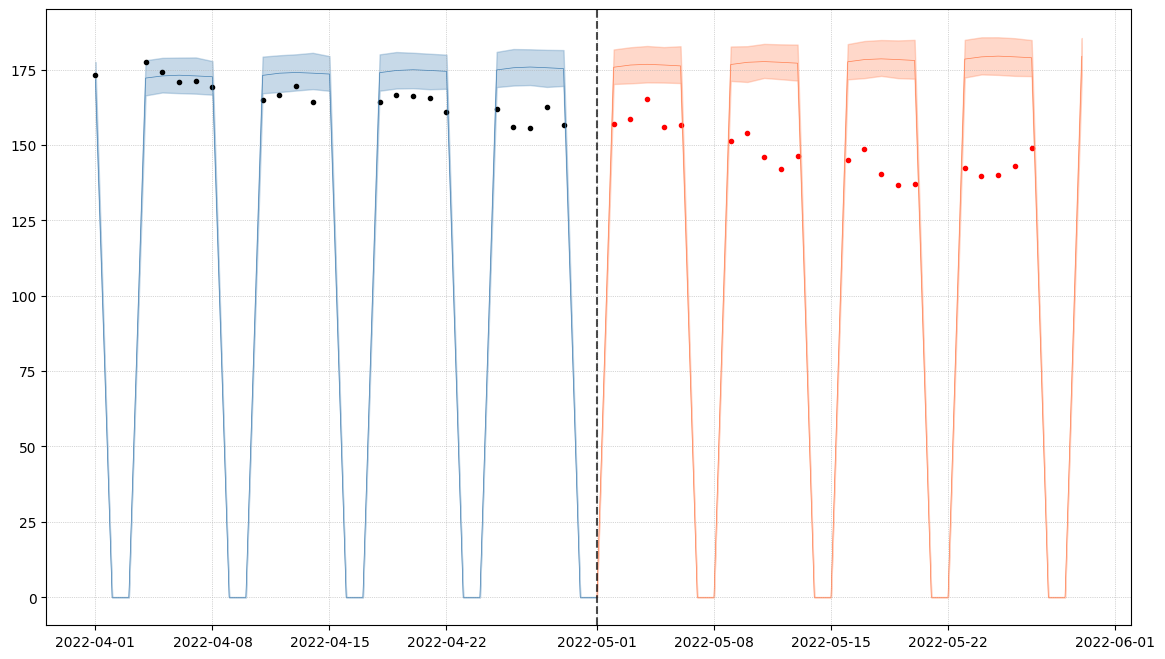

In [551]:
f, ax = plot_predictions(result, '2022-04-01')

In [560]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [558]:
result = result.dropna()
mean_squared_error(result.loc['2022-05-01':'2022-05-30','y'],result.loc['2022-05-01':'2022-05-30','yhat'])

972.3784565186127

In [561]:
result = result.dropna()
mean_absolute_error(result.loc['2022-05-01':'2022-05-30','y'],result.loc['2022-05-01':'2022-05-30','yhat'])

29.968380165075267

# extra regressors are added


In [539]:
m = Prophet(seasonality_mode='multiplicative',
            yearly_seasonality=True, 
            weekly_seasonality=True,
            daily_seasonality=False)

In [540]:
m.add_regressor('confirmed', mode='multiplicative')
m.add_regressor('google_stock', mode='multiplicative')


In [ ]:
forecast = m.predict(futures)